In [12]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import os

In [13]:

def load_activations(model_type, layers, tuning):
    activations = {}
    base_path = f'../data_store/ablated_llama-2-7b/{tuning}'
    
    for layer in layers:
        harmless_path = os.path.join(base_path, f'harmless_layer{layer}.pt')
        harmful_path = os.path.join(base_path, f'harmful_layer{layer}.pt')
        intervention_path = os.path.join(base_path, f'intervention_layer{layer}.pt')
        
        activations[layer] = {
            'harmless': torch.load(harmless_path),
            'harmful': torch.load(harmful_path),
            'intervention': torch.load(intervention_path)
        }
    
    return activations

def plot_activations_pca(activations, layers, tuning, refusal_rate):
    fig, axs = plt.subplots(len(layers) // 2, 2, figsize=(20, 16))
    axs = axs.flatten()

    for idx, layer in enumerate(layers):
        layer_activations = activations[layer]
        
        # combine activations & apply PCA
        all_activations = torch.cat([
            layer_activations['harmless'], 
            layer_activations['harmful'], 
            layer_activations['intervention']
        ], dim=0)
        
        pca = PCA(n_components=2)
        projected_activations = pca.fit_transform(all_activations.cpu().numpy())

        n = len(layer_activations['harmful'])
        harmless_proj = projected_activations[:n]
        harmful_proj = projected_activations[n:2*n]
        intervention_proj = projected_activations[2*n:]

        # plot on the corresponding subplot
        axs[idx].scatter(harmless_proj[:, 0], harmless_proj[:, 1], color='green', label='Harmless', alpha=0.6)
        axs[idx].scatter(harmful_proj[:, 0], harmful_proj[:, 1], color='red', label='Harmful', alpha=0.6)
        axs[idx].scatter(intervention_proj[:, 0], intervention_proj[:, 1], color='blue', label='Intervention', alpha=0.6)

        axs[idx].legend()
        axs[idx].set_title(f"PCA of Activations at Layer {layer}")
        axs[idx].set_xlabel("PC 1")
        axs[idx].set_ylabel("PC 2")

    fig.suptitle(f"Refusal Direction PCA\nBase model: ablated_llama-2-7b\nTuning: {tuning}\nRefusal Rate: {refusal_rate}", fontsize=16)

    plt.tight_layout()
    plt.savefig(f"refusal_direction_pca_multi_layer_{tuning}.png")
    plt.show()
    plt.close()


/tmp/ipykernel_9033/2897362782.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  'harmless': torch.load(harmless_path),
/tmp/ipykernel_9033/2897362782.py:12: FutureWarnin

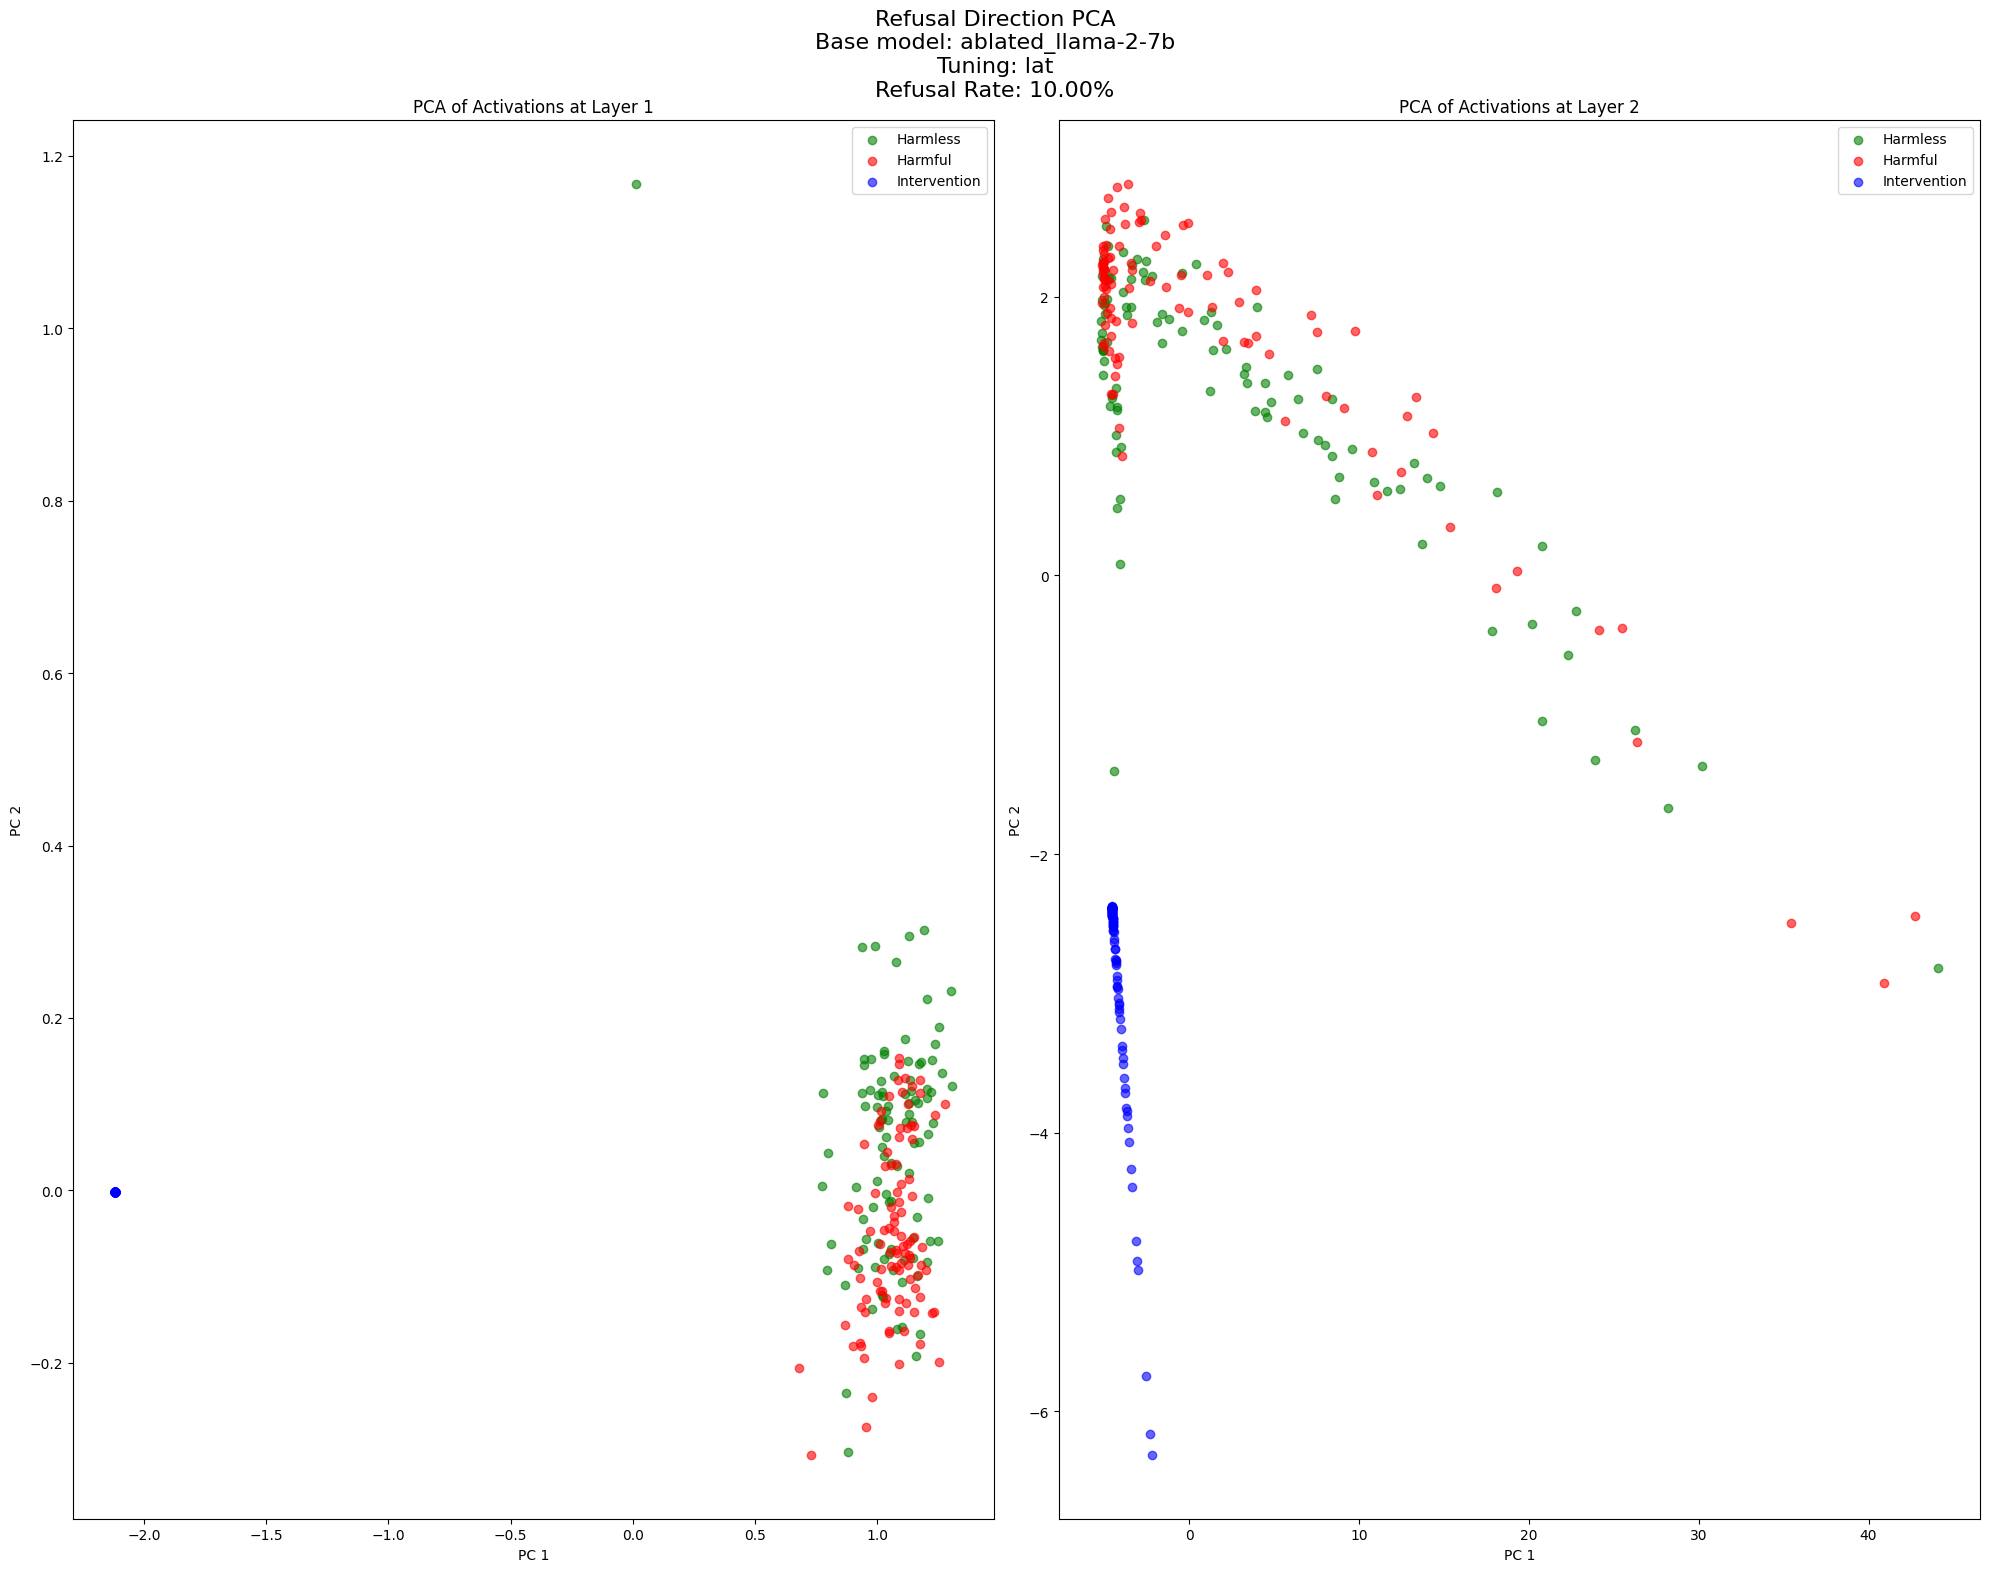

In [18]:

layers_to_analyze = [1, 2] # all mapped to 1, 2, 3, 4, 8, 12, 16, 20
tuning = 'lat'  # 'at', 'lat', or 'baseline'
refusal_rate = "10.00%"

activations = load_activations('ablated_llama-2-7b', layers_to_analyze, tuning)
plot_activations_pca(activations, layers_to_analyze, tuning, refusal_rate)